In [33]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, root_mean_squared_error
from sklearn.tree import export_text

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [6]:
data.fillna(0, inplace=True)

In [7]:
data.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,0.0,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,0.0,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [16]:
df_full_train, df_test = train_test_split(data.drop(columns=['fuel_efficiency_mpg']), test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(len(df_train), len(df_test), len(df_val))

y_full_train, y_test = train_test_split(data['fuel_efficiency_mpg'], test_size=0.2, random_state=1)
y_train, y_val = train_test_split(y_full_train, test_size=0.25, random_state=1)
print(len(y_train), len(y_test), len(y_val))

5822 1941 1941
5822 1941 1941


In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

In [25]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [26]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
y_pred = dtr.predict(X_val)

In [30]:
print(export_text(dtr, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [34]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = rfr.predict(X_val)
root_mean_squared_error(y_pred, y_val)

0.4595777223092726

In [37]:
ns = []
rmses = []
for n in range(10, 200, 10):
    rfr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_val)
    rmses.append(root_mean_squared_error(y_pred, y_val))
    ns.append(n)

df_rmse = pd.DataFrame(index=ns, data=rmses, columns=['rmse'])  

<Axes: >

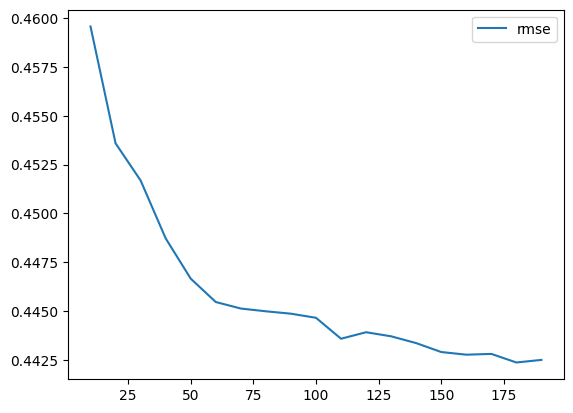

In [44]:
df_rmse.plot()

In [45]:
ns = []
rmses = []
for maxd in [10, 15, 20, 25]:
    for n in range(10, 200, 10):
        rfr = RandomForestRegressor(n_estimators=n, max_depth=maxd, random_state=1, n_jobs=-1)
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_val)
        rmses.append(root_mean_squared_error(y_pred, y_val))
        ns.append((maxd, n))

df_rmse = pd.DataFrame(index=ns, data=rmses, columns=['rmse'])

In [46]:
df_rmse

,rmse
"(10, 10)",0.450249
"(10, 20)",0.446857
"(10, 30)",0.445474
"(10, 40)",0.443067
"(10, 50)",0.441957
...,...
"(25, 150)",0.442937
"(25, 160)",0.442800
"(25, 170)",0.442843
"(25, 180)",0.442409


In [56]:
idx = pd.MultiIndex.from_tuples(df_rmse.index)
df_rmse = pd.DataFrame(index=idx, data=rmses, columns=['rmse'])
df_rmse.index.names = ['max_depth', 'n_estimators']
df_rmse.groupby('max_depth').mean()

,rmse
max_depth,
10,0.441911
15,0.445578
20,0.446429
25,0.446090


In [64]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)
# y_pred = rfr.predict(X_val)
# root_mean_squared_error(y_pred, y_val)
pd.DataFrame(index=list(dv.get_feature_names_out()), data=rfr.feature_importances_, columns=['imp']).sort_values(by='imp', ascending=False)

,imp
vehicle_weight,0.959150
horsepower,0.015998
acceleration,0.011480
engine_displacement,0.003273
model_year,0.003212
num_cylinders,0.002343
num_doors,0.001635
origin=USA,0.000540
origin=Europe,0.000519
origin=Asia,0.000462


In [65]:
import xgboost as xgb

In [66]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [70]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [71]:
y_pred = model.predict(dval)
root_mean_squared_error(y_pred, y_val)

0.42622800553359225